## Headings

In [1]:
import sys, os
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.python.ops import math_ops
from ESN import EchoStateRNNCell
import matplotlib.pyplot as plt

# memory growth
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

# random numbers
random_seed = np.frombuffer(os.urandom(4), dtype=np.uint32)[0]
print("seed: ", random_seed)

C:\Users\User\anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


seed:  1233225421


## Global variables

In [3]:
batches = 20
stime = 50
epochs = 400
num_units = 15
num_inputs = 1
num_outputs = 1
   
activation = lambda x: math_ops.tanh(x)

## Dataset

In this exmaple the input has the role of initializing the network activity. We use the exponential trace of an impulse at time $t_{0}$. The target trajectory to reproduce is a sinusoid function.

In [4]:
t = np.linspace(0, 1, stime).reshape(1,-1, 1).astype("float32")
inputs = np.exp(-t*200)
targets = np.cos(t*6*np.pi)


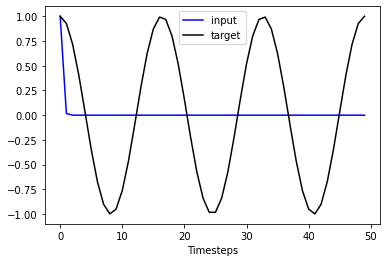

In [5]:
i, = plt.plot(inputs[0], color="blue")
t, = plt.plot(targets[0], color="black")
plt.xlabel("Timesteps")
plt.legend([i, t], ['input', "target"])

## The model

We build a model containing the ESN as an hinner layer. The 1-dimensional input goes to the inner units. The output layer is composed of one readout that is supposed to reproduce the target given the input at $t_0$.
The trainable parameters of the model are the 'num_units' weights from ESN units to the readout unit, plus the four meta-parameters of the ESN (***decay*** -- the integration step of the units, ***alpha*** -- the "dynamic rotation coefficient", ***ws*** -- the scaling of the 'num_units' random fixed weights from the input to the ESN units and ***rho*** -- the spectral radius (the use of alpha allows to push it over the limits)) 

In [5]:
# Init the ESN cell
cell = EchoStateRNNCell(units=num_units, 
                        activation=activation, 
                        decay=0.1, 
                        epsilon=1e-20,
                        alpha=0.5,
                        optimize=True,
                        optimize_vars=["rho", "decay", "alpha", "sw"],
                        seed=random_seed)

# Build the recurrent layer containing the ESN cell
recurrent_layer = keras.layers.RNN(cell, input_shape=(stime, num_inputs), 
                                   return_sequences=True, name="nn")
# Build the readout layer
output = keras.layers.Dense(num_outputs, name="readouts")
# initialize the adam optimizer for training
optimizer = keras.optimizers.Adam(learning_rate=0.01)

# put all together in a keras sequential model
model = keras.models.Sequential()
model.add(recurrent_layer)
model.add(output)

In [6]:
model.compile(loss="mse", optimizer=optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
nn (RNN)                     (None, 50, 15)            471       
_________________________________________________________________
readouts (Dense)             (None, 50, 1)             16        
Total params: 487
Trainable params: 20
Non-trainable params: 467
_________________________________________________________________


## Rollout before optimization

Here's what the dynamics of the ESN looks like given the input before optimization of the meta-parameters.

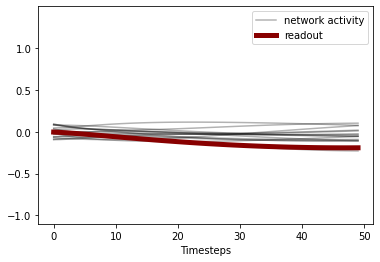

In [7]:
inner = model.get_layer("nn")(inputs) 
outputs = model(inputs) 

r = plt.plot(inner.numpy()[0], color = "black", alpha=0.3)
o, = plt.plot(outputs.numpy()[0], lw=5, color ="#880000")
plt.xlabel("Timesteps")
plt.ylim([-1.1,1.5])
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.legend([r[0],o], ["network activity", "readout"])

## Model fitting

In [8]:
hist = model.fit(inputs, targets, epochs=epochs, verbose=0)

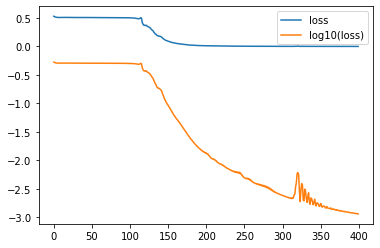

In [9]:
loss, = plt.plot(hist.history['loss'])
logloss, = plt.plot(np.log10(hist.history['loss']))
plt.legend([loss, logloss], ["loss","log10(loss)"])

## Rollout after optimization

Here's what the dynamics of the ESN looks like given the input ***after*** optimization of the meta-parameters.

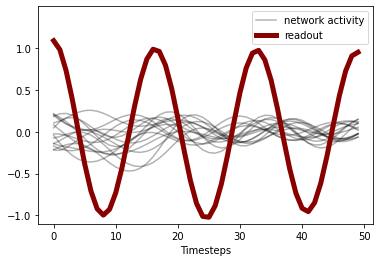

In [10]:
inner = model.get_layer("nn")(inputs) 
outputs = model(inputs) 

r = plt.plot(inner.numpy()[0], color = "black", alpha=0.3)
o, = plt.plot(outputs.numpy()[0], lw=5, color ="#880000")
plt.xlabel("Timesteps")
plt.ylim([-1.1,1.5])
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.legend([r[0],o], ["network activity", "readout"])

## Readout activity optimization

Here's what the readout activity of looks like given the input ***after*** optimization.

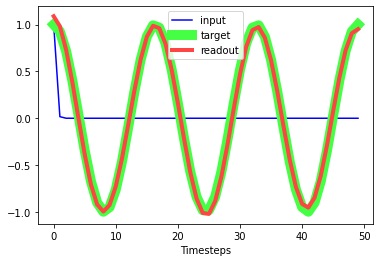

In [11]:
outputs = model(inputs) 
i, = plt.plot(inputs[0], color="blue")
t, = plt.plot(targets[0], color="#44ff44", lw=10)
o, = plt.plot(outputs[0], color="#ff4444", lw=4)
plt.xlabel("Timesteps")
plt.legend([i, t, o], ['input', "target", "readout"])